In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/wisdm_individual_windows_20.p','rb'))

In [3]:
X = np.array(np.nan_to_num(X))

In [4]:
def get_train_test_val_data(X_hr,y_participant,y_time,y_activity):
    all_data = pd.DataFrame({'x':np.arange(X_hr.shape[0]),'y':y_participant,'time':y_time,'activity':y_activity})
    train_percentage = .6
    val_percentage = train_percentage+.1
    def split_data(df):
        df = df.sort_values('time').reset_index(drop=True)
        n = df.shape[0]
        train_index = df['x'].values[:int(n*train_percentage)]
        val_index = df['x'].values[int(n*train_percentage):int(n*val_percentage)]
        test_index = df['x'].values[int(n*val_percentage):]
        return pd.DataFrame({'train':[list(train_index)],'val':[list(val_index)],'test':[list(test_index)]})

    index_df = all_data.groupby(['y','activity'],as_index=False).apply(split_data)

    from functools import reduce
    train_index = np.array(reduce(lambda a,b:a+b,index_df['train'].values))
    val_index = np.array(reduce(lambda a,b:a+b,index_df['val'].values))
    test_index = np.array(reduce(lambda a,b:a+b,index_df['test'].values))


    train_x,train_y = X_hr[train_index],y_participant[train_index]
    val_x,val_y = X_hr[val_index],y_participant[val_index]
    test_x,test_y = X_hr[test_index],y_participant[test_index]
    return train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index 

In [5]:
window_size = 20
n_timesteps = window_size*20
n_channels = 1
train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index  = get_train_test_val_data(X[:,:,:],
                                                                                                      y_participant,
                                                                                                      y_time,
                                                                                                      y_activity)
train_activity = y_activity[train_index]
test_activity = y_activity[test_index]

In [6]:
train_x.shape,test_x.shape,val_x.shape,train_y.shape

((10650, 400, 3), (6189, 400, 3), (1970, 400, 3), (10650,))

In [7]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
from keras.layers import Conv1D,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input,GRU
from keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats.mstats import winsorize

4 Physical GPUs, 1 Logical GPU


In [8]:
def get_model(input_shape=(400,3),act='relu',loss="categorical_crossentropy",opt='adam',
              n_classes=350,n_output = 15):
    
    
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(Conv1D(100,40,input_shape=input_shape,activation='selu',kernel_initializer='normal',padding='same'))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Conv1D(50,40,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
#     model.add(BatchNormalization())
#     model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
#     model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    
    model.add(Conv1D(200,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(BatchNormalization())
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Dropout(.2))
    model.add(Flatten())
#     model.add(Dense(n_classes,activation='relu'))
#     model.add(Dense(n_output*2,activation='relu'))
    model.add(Dense(n_output,activation=None))
#     model.summary()
    input_ = Input(shape=input_shape)
    reshaped_input = Reshape(input_shape)(input_)
    embedding = model(reshaped_input)
    embedding = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='feature')(embedding)
    
#     class_embedding = Dense(n_output,activation='sigmoid')(final_embedding)
    y_output = Dense(n_output,activation='softmax',name='output')(embedding) 
    model1 = Model(input_,y_output)
#     model1.compile(loss={'output':tf.keras.losses.SparseCategoricalCrossentropy(),
#                         'feature':tfa.losses.TripletSemiHardLoss()},optimizer=opt,
#                    loss_weights={'output':1,'feature':0})
    model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam')
    return model1

model1 = get_model(input_shape=(n_timesteps,3))
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 3)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 400, 3)            0         
_________________________________________________________________
sequential (Sequential)      (None, 15)                991165    
_________________________________________________________________
feature (Lambda)             (None, 15)                0         
_________________________________________________________________
output (Dense)               (None, 15)                240       
Total params: 991,405
Trainable params: 990,205
Non-trainable params: 1,200
_________________________________________________________________


In [9]:
n_classes = 300
n_output = len(np.unique(y_participant))
model = get_model(input_shape=(n_timesteps,3),n_classes=n_classes,n_output=n_output) 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400, 3)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 400, 3)            0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 51)                1077601   
_________________________________________________________________
feature (Lambda)             (None, 51)                0         
_________________________________________________________________
output (Dense)               (None, 51)                2652      
Total params: 1,080,253
Trainable params: 1,079,053
Non-trainable params: 1,200
_________________________________________________________________


In [10]:
from keras.models import load_model
filepath = '../model_files/base_cnn_60_seconds_raw_acl_classification_wisdm.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=400, 
                    batch_size=200,callbacks=callbacks_list,shuffle=True,verbose=1)

Epoch 1/400
54/54 [==============================] - ETA: 0s - loss: 3.7403
Epoch 00001: val_loss improved from inf to 3.89626, saving model to ../model_files/base_cnn_60_seconds_raw_acl_classification_wisdm.hdf5
54/54 [==============================] - 3s 47ms/step - loss: 3.7403 - val_loss: 3.8963
Epoch 2/400
53/54 [============================>.] - ETA: 0s - loss: 3.5758
Epoch 00002: val_loss improved from 3.89626 to 3.81748, saving model to ../model_files/base_cnn_60_seconds_raw_acl_classification_wisdm.hdf5
54/54 [==============================] - 1s 28ms/step - loss: 3.5755 - val_loss: 3.8175
Epoch 3/400
52/54 [===========================>..] - ETA: 0s - loss: 3.4512
Epoch 00003: val_loss improved from 3.81748 to 3.66071, saving model to ../model_files/base_cnn_60_seconds_raw_acl_classification_wisdm.hdf5
54/54 [==============================] - 1s 28ms/step - loss: 3.4504 - val_loss: 3.6607
Epoch 4/400
54/54 [==============================] - ETA: 0s - loss: 3.3140
Epoch 00004: 

In [11]:
model.load_weights(filepath)
y_pred = model.predict(test_x).argmax(axis=1)

In [12]:
from sklearn.metrics import classification_report,accuracy_score

print(classification_report(test_y,y_pred),accuracy_score(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76       109
           1       0.52      0.37      0.43       109
           2       0.67      0.65      0.66       108
           3       0.49      0.42      0.45       108
           4       0.92      0.96      0.94       251
           5       0.49      0.51      0.50       108
           6       0.56      0.57      0.57       108
           7       0.73      0.66      0.69       108
           8       0.50      0.58      0.54       108
           9       0.56      0.32      0.40       111
          10       0.90      0.83      0.87       108
          11       0.50      0.59      0.54       111
          12       0.65      0.53      0.59       113
          13       0.96      0.99      0.97       251
          14       0.46      0.45      0.45       112
          15       0.40      0.42      0.41       108
          16       0.46      0.54      0.50       110
          17       0.87    

In [13]:
test_hr = y_hr[test_index]

In [14]:
test_df = pd.DataFrame({'hr':test_hr,
                        'original':test_y,
                        'prediction':y_pred,
                        'activity':test_activity,
                        'data':[np.array(a) for a in test_x]})

In [15]:
test_df.shape

(6189, 5)

<ipython-input-27-c66f0b1e47e1>:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dps" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../data/wisdm_20_base_model_accuracy_by_participant_activity.png',dps=1e6)


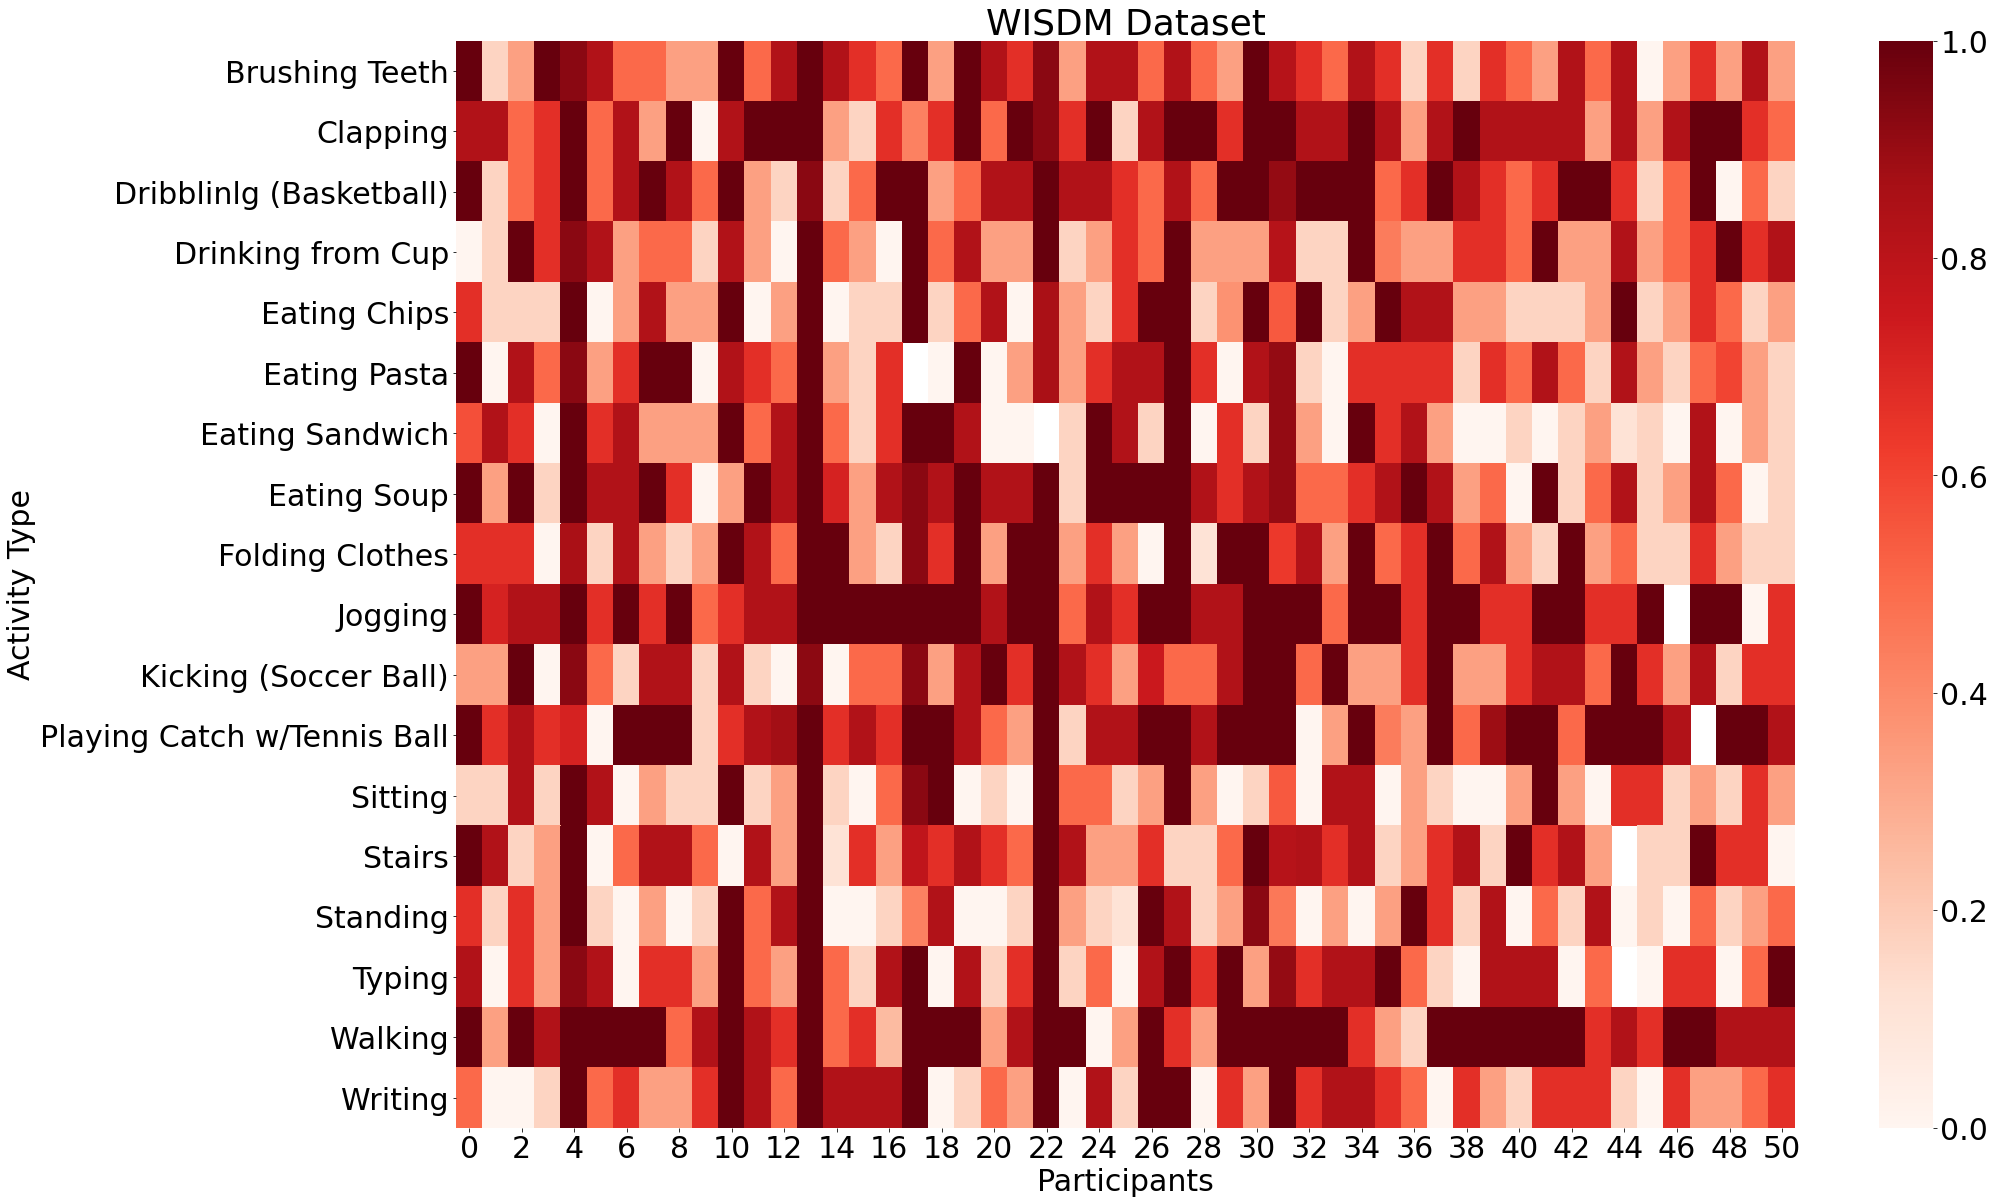

In [27]:
ds = test_df.groupby(['activity','original'],as_index=False).apply(lambda a:accuracy_score(a['original'],a['prediction']))

ds.columns = ['activity','original','accuracy']

labels = ['Walking','Jogging','Stairs','Sitting','Standing','Typing','Brushing Teeth','Eating Soup',
'Eating Chips','Eating Pasta','Drinking from Cup','Eating Sandwich','Kicking (Soccer Ball)','Playing Catch w/Tennis Ball','Dribblinlg (Basketball)','Writing',
'Clapping','Folding Clothes']
label_dict = {i:a for i,a in enumerate(labels)}
ds['activity'] = ds['activity'].apply(lambda a:label_dict[a])
# ds['original'] = ds['original'].apply(lambda a:'p'+str(a))

matrix = pd.pivot_table(ds,values='accuracy',columns='original',index='activity',aggfunc='mean')

import seaborn as sns
# sns.set_palette("Reds")
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(30,20))
sns.heatmap(matrix,cmap='Reds',annot=False,fmt='.1f')
plt.xlabel('Participants')
plt.ylabel('Activity Type')
plt.title('WISDM Dataset')
plt.savefig('../data/wisdm_20_base_model_accuracy_by_participant_activity.png',dps=1e6)
plt.show()

In [28]:
?pd.pivot_table

Signature:
pd.pivot_table(
    data,
    values=None,
    index=None,
    columns=None,
    aggfunc='mean',
    fill_value=None,
    margins=False,
    dropna=True,
    margins_name='All',
    observed=False,
) -> 'DataFrame'
Docstring:
Create a spreadsheet-style pivot table as a DataFrame.

The levels in the pivot table will be stored in MultiIndex objects
(hierarchical indexes) on the index and columns of the result DataFrame.

Parameters
----------
data : DataFrame
values : column to aggregate, optional
index : column, Grouper, array, or list of the previous
    If an array is passed, it must be the same length as the data. The
    list can contain any of the other types (except list).
    Keys to group by on the pivot table index.  If an array is passed,
    it is being used as the same manner as column values.
columns : column, Grouper, array, or list of the previous
    If an array is passed, it must be the same length as the data. The
    list can contain any of the other types 

In [ ]:
from scipy.stats import mode
n = 100
len_col = np.arange(2,23,2)
# for l in len_col:
def get_ensemble_score(df):
#     print(df.shape)
    if df.shape[0]<22:
        return pd.DataFrame([],columns=['ensemble_size','accuracy','participant'])
    results = []
    original = df['original'].values[0]
    for l in len_col:
        count = 0
        for _ in range(n): 
            ensemble_prediction = mode(df.sample(l)['prediction'])[0][0]
            if original==ensemble_prediction:
                count+=1
        results.append(count/n)
    return pd.DataFrame({'ensemble_size':np.array(len_col),
                         'accuracy':results,
                         'participant':[original]*len(len_col),
                         'activity':[df['activity'].values[0]]*len(len_col)})

from joblib import Parallel,delayed


emsemble_df = pd.concat(Parallel(n_jobs=-1,verbose=2)(delayed(get_ensemble_score)(df) for i,df in test_df.groupby(['original','activity'],as_index=False)))
# test_df.groupby(['original','activity']).apply(get_ensemble_score).reset_index(drop=True)

In [ ]:
labels = ['Walking','Jogging','Stairs','Sitting','Standing','Typing','Brushing Teeth','Eating Soup',
'Eating Chips','Eating Pasta','Drinking from Cup','Eating Sandwich','Kicking (Soccer Ball)','Playing Catch w/Tennis Ball','Dribblinlg (Basketball)','Writing',
'Clapping','Folding Clothes','Code']
label_dict = {i:a for i,a in enumerate(labels)}

In [ ]:
ensemble_df = emsemble_df[emsemble_df.activity<90]
ensemble_df = ensemble_df.groupby(['activity','ensemble_size'],as_index=False).mean()
ensemble_df['label'] = ensemble_df['activity'].apply(lambda a:label_dict[a])
sns.color_palette("tab10")
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(20,10))
sns.barplot(x='label',y='accuracy',hue='ensemble_size',data=ensemble_df,linewidth=3)
plt.ylabel('Accuracy')
plt.xlabel('Number of Windows')
plt.legend(ncol=3)
plt.title('ACL Only Model')
plt.xticks(rotation=90)
plt.ylim([0,1.2])
# plt.savefig('acl_only.png')
plt.show()

In [ ]:
ensemble_df = emsemble_df[emsemble_df.activity>9]
ensemble_df = ensemble_df.groupby(['activity','ensemble_size'],as_index=False).mean()
ensemble_df['label'] = ensemble_df['activity'].apply(lambda a:label_dict[a])
sns.color_palette("tab10")
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(20,10))
sns.lineplot(x='ensemble_size',y='accuracy',hue='label',data=ensemble_df,linewidth=3)
plt.ylabel('Accuracy')
plt.xlabel('Number of Windows')
plt.legend(ncol=3)
plt.title('ACL Only Model')
plt.xticks(rotation=90)
plt.ylim([0,1.2])
# plt.savefig('acl_only.png')
plt.show()

In [ ]:
from collections import Counter
Counter(test_df.groupby(['original','activity']).count()['data'])

In [ ]:
import seaborn as sns
emsemble_df['participant'] = emsemble_df['participant'].astype(str)
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.lineplot(x='ensemble_size',y='accuracy',hue='participant',data=emsemble_df,linewidth=3)
plt.ylabel('Accuracy')
plt.xlabel('Number of Windows')
plt.legend(ncol=3)
plt.title('ACL Only Model')
# plt.savefig('acl_only.png')
plt.show()

In [ ]:
import seaborn as sns
emsemble_df['participant'] = emsemble_df['participant'].astype(str)
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.lineplot(x='ensemble_size',y='accuracy',hue='participant',data=emsemble_df,linewidth=3)
plt.ylabel('Accuracy')
plt.xlabel('Number of Windows')
plt.legend(ncol=3)
plt.title('ACL Only Model')
# plt.savefig('acl_only.png')
plt.show()

In [ ]:
activity_dict = {0:'No Label',
                1:'Sitting',
                2:'Stairs',
                3:'Soccer',
                4:'Cycling',
                5:'Driving',
                6:'Lunch',
                7:'Walking',
                8:'Working'}
# activity_dict_reverse = {activity_dict[k]:k f}

In [ ]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
hrs = np.arange(50,150,10)
test_df['discrete_hr'] = test_df['hr'].apply(lambda a:find_nearest(hrs,a))

In [ ]:
test_df.head()

In [ ]:
def get_score(df):
#     print(df['original'].values[0],df['discrete_hr'].values[0],
#           accuracy_score(df['original'],df['prediction']))
    return pd.DataFrame([[df['original'].values[0],df['discrete_hr'].values[0],
                         accuracy_score(df['original'],df['prediction']),
                         df['activity'].values[0]]],columns=['original',
                                                                                    'heart_rate',
                                                                                    'accuracy',
                                                                                   'activity'])
heart_rate_scores = test_df.groupby(['original','activity'],as_index=False).apply(get_score)
heart_rate_scores = heart_rate_scores.reset_index(drop=True)

In [ ]:
import seaborn as sns
heart_rate_scores['activity'] = heart_rate_scores['activity'].apply(lambda a:activity_dict[a])

In [ ]:
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.barplot(x='activity',y='accuracy',data=heart_rate_scores)
# for p in heart_rate_scores['original'].unique():
#     temp = heart_rate_scores[heart_rate_scores.original==p]
#     plt.plot(temp['heart_rate'],temp['accuracy'],'--*')
plt.ylabel('Accuracy')
# plt.xlabel('Number of Windows')
plt.xticks(rotation=10)
plt.title('ACL only')
plt.savefig('acl_by_activity.png')
plt.show()

In [ ]:
test_df['magnitude'] = test_df['data'].apply(lambda a:np.sqrt(np.sum(np.square(a[:,1:]),axis=1)))

In [ ]:
def get_result_df(test_df,f_acl,f_ppg,n1=50,n2=50):
    test_df['acl_std'] = test_df['magnitude'].apply(lambda a:f_acl(a))
    test_df['ppg_std'] = test_df['data'].apply(lambda a:f_ppg(a[:,0]))

    acl_std_array = np.linspace(test_df['acl_std'].min(),test_df['acl_std'].max(),n1)
    test_df['acl_std_discrete'] = test_df['acl_std'].apply(lambda a:find_nearest(acl_std_array,a))
    test_df['acl_std_discrete'] = test_df['acl_std_discrete'].apply(lambda a:int(100*(a/test_df['acl_std_discrete'].max())))

    ppg_std_array = np.linspace(test_df['ppg_std'].min(),test_df['ppg_std'].max(),n2)
    test_df['ppg_std_discrete'] = test_df['ppg_std'].apply(lambda a:find_nearest(ppg_std_array,a))
    test_df['ppg_std_discrete'] = test_df['ppg_std_discrete'].apply(lambda a:int(100*(a/test_df['ppg_std_discrete'].max())))

    def get_result(df):
        acl = df['acl_std_discrete'].values[0]
        ppg = df['ppg_std_discrete'].values[0]
        result = accuracy_score(df['original'],df['prediction'])
        return pd.DataFrame([[acl,ppg,result]],columns=['acl_feature','ppg_feature','accuracy'])
    result_df = test_df.groupby(['acl_std_discrete','original']).apply(get_result)
    return result_df

In [ ]:
from scipy.stats import iqr,skew,kurtosis
result_df = get_result_df(test_df.copy(),np.std,skew,50,10)
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.lineplot(x='acl_feature',y='accuracy',data=result_df)
plt.xlabel('Standard Deviation of the Magnitude of Accelerometer - discrete levels')
plt.ylabel('REID accuracy from ACL')
plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig('acl_reid_vs_acl_std.png')
plt.show()

In [ ]:
from alibi.explainers import IntegratedGradients
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
ig  = IntegratedGradients(model,
                          layer=model.layers[1],
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

explanation = ig.explain(test_x[:,:,:1],
                         baselines=None,
                         target=y_pred)

In [ ]:
explanation.attributions.shape

In [ ]:
test_df['attribution'] = list([np.array(a) for a in explanation.attributions])

In [ ]:
test_df['magnitude'] = test_df['data'].apply(lambda a:np.sqrt(np.sum(np.square(a[:,1:]),axis=1)))

In [ ]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
count = 0
for i,row in test_df[::-1].iterrows():
    if activity_dict[row['activity']]!='Lunch':
        continue
    if row['original']!=row['prediction']:
        continue
    count+=1
    if count>100:
        break
    print(row['attribution'].shape)
    fig,ax = plt.subplots(3,1,figsize=(10,8))
#     ax[0].plot(row['data'][:,1:])
    ax[0].plot(row['magnitude'],'r')
    ax[0].set_ylim([-.05,.05])
    ax[1].bar(np.arange(256),MinMaxScaler().fit_transform(np.abs(row['attribution'])).reshape(-1))
    ax[2].plot(row['data'][:,:1].reshape(-1),'g')
    plt.show()